In [72]:
import pandas as pd
import numpy as np
import six
from six.moves import cPickle as cpik
import tensorflow as tf
import keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.layers.recurrent import LSTM,GRU
from keras import backend as K
from timeit import default_timer as timer
from sklearn.grid_search import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
import six
from six.moves import cPickle as cpik
from sklearn import preprocessing

### 1- Functions of reading Data, accuracy measures, etc.

In [30]:
def build_dl_dataset_by_ts(df, ts):
    '''
    Build up a (data_size * 11 * 7 * 7 * 2) dataset for both traning and testing
    
    Input
    df: a dateframe
    ts: time_steps, use how many previous time frame to predict the next one, e.g., if it is 11, then use the
        previous 11 date to predict current 1.
    
    Output
    Training set and testing set
    
    '''
    fids = df['FishnetID'].unique().tolist()
    #print(fids)
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []
    
    for fid in fids:
        df_current = df[df['FishnetID'] == fid].reset_index(drop = True) #original dataset has been ordered by time.
        df_current_len = df_current.shape[0] # overall length of current data 
        if (df_current_len - ts - 1)>0:
            for i in range(df_current_len - ts - 1):
                # current slice of input data
                X_train_cur = []
                Y_train_cur = []
                # append every X by time steps
                for x_v in df_current['neighbours_index_image'].iloc[i : (i+ts)].values:
                    X_train_cur.append(x_v)
                    #print(np.array(X_cur).shape)    
                X_train.append(np.array(X_train_cur))  
                # append very Y by time steps
                for y_v in df_current['PerformanceTarget'].iloc[i+1 : (i+ts+1)].values:
                    Y_train_cur.append(y_v)
                Y_train.append(np.array(Y_train_cur))
            
            for i in range(df_current_len - ts - 1, df_current_len - ts):
                # current slice of input data
                X_test_cur = []
                Y_test_cur = []
                # append every X by time steps
                for x_v in df_current['neighbours_index_image'].iloc[i : (i+ts)].values:
                    X_test_cur.append(x_v)
                    #print(np.array(X_cur).shape)
                X_test.append(np.array(X_test_cur))  
                # append very Y by time steps
                for y_v in df_current['PerformanceTarget'].iloc[i+1 : ].values:
                    Y_test_cur.append(y_v)
                Y_test.append(np.array(Y_test_cur))
        else:
            for i in range(df_current_len - ts):
                # current slice of input data
                X_cur = []
                Y_cur = []
                # append every X by time steps
                for x_v in df_current['neighbours_index_image'].iloc[i : (i+ts)].values:
                    X_cur.append(x_v)
                    #print(np.array(X_cur).shape)    
                X_train.append(np.array(X_cur))
                X_test.append(np.array(X_cur))  
                # append very Y by time steps
                for y_v in df_current['PerformanceTarget'].iloc[i+1 : (i+ts+1)].values:
                    Y_cur.append(y_v)
                Y_train.append(np.array(Y_cur))
                Y_test.append(np.array(Y_cur))      
    return (X_train, Y_train, X_test, Y_test)


#MAPE loss function self defined for keras
def mape_loss(y_true, y_pred):
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),
                                            K.epsilon(),
                                            None))
    return 100. * K.mean(diff, axis=-1)


# MAPE loss for calculate test result.
def mape(y_p, y):
    y[y == 0] = 0.00001
    diff = np.abs((y_p - y) / y)
    #print(diff)
    return 100. * np.mean(diff)



# RMSE loss for calculate test result.
def rmse(y_p, y):
    diff = np.sqrt((y_p - y)**2)# np.sum()
    return np.mean(diff)

In [3]:
# def CNN_LSTM_MODEL_RMSprop
def cnn_on_lstm_rms_model(CONV2D_1_DEPTH, CONV2D_2_DEPTH, CNN_DP, #CNN archi related
                          LSTM_DP, LSTM_UNITS, #LSTM archi related# RMSprop related
                          inputshapes, loss_fnc):
    model = Sequential()
    # add two time-distributed convolutional layers for feature extraction
    model.add(TimeDistributed(Conv2D(CONV2D_1_DEPTH, (3, 3), activation='relu'), input_shape = inputshapes))
    #model.add(TimeDistributed(Conv2D(16, (4, 4), activation='relu')))
    model.add(TimeDistributed(Conv2D(CONV2D_2_DEPTH, (5, 5), activation='relu')))


    # extract features and dropout 
    model.add(TimeDistributed(Flatten()))
    model.add(Dropout(CNN_DP))
    #print(123123123)
    # input to LSTM
    model.add(LSTM(LSTM_UNITS, return_sequences=True, dropout=LSTM_DP)) #input_shape=(5, 512), 
    #print(123123123)
    # classifier with sigmoid activation for multilabel
    model.add(Dense(1, activation='tanh'))
    #model.add(TimeDistributed(Dense(1, activation='tanh')))

    # compile the model with binary_crossentropy loss for multilabel
    #Rmsprop = keras.optimizers.RMSprop(lr=RMSprop_LR, rho=RMSprop_RHO, 
    #                                   epsilon=None, decay=RMSprop_DECAY)
    #model.compile(optimizer= Rmsprop, loss = loss_fnc)
    #keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    model.compile(optimizer= 'rmsprop', loss = mape_loss)
    # look at the params before training
    #model.summary()
    return model

In [4]:
def get_performance(num_interates, X_train, Y_train, X_test, Y_test):
    
    inputshapes = X_train.shape[1:]
    cnnlstm_train_mape = []
    cnnlstm_test_mape = []
    cnnlstm_train_rmse= []
    cnnlstm_test_rmse =[]
    
    cnnlstm_train_error_85 = []
    cnnlstm_test_error_85 = []
    
    for i in range(num_interates):
        cnnlstm = cnn_on_lstm_rms_model(64, 64, 0.1, 0.1, 64, inputshapes, mape_loss)
        cnnlstm.fit(X_train, Y_train, batch_size = 64,epochs=50,verbose=0) #
        
        # prediction
        Y_train_pred = cnnlstm.predict(X_train)
        Y_test_pred = cnnlstm.predict(X_test)
        
        Y_train_pred = Y_train_pred[:,-1,:].flatten()
        Y_train_true = Y_train[:,-1,:].flatten()
        Y_test_pred = Y_test_pred[:,-1,:].flatten()
        Y_test_true = Y_test[:,-1,:].flatten()
        
        # mape train
        cnnlstm_train_mape.append(mape(Y_train_pred, Y_train_true))
        # mape test
        cnnlstm_test_mape.append(mape(Y_test_pred, Y_test_true))
        # rmse train
        cnnlstm_train_rmse.append(rmse(Y_train_pred, Y_train_true))
        # rmse test
        cnnlstm_test_rmse.append(rmse(Y_test_pred, Y_test_true)) 
        
        cnnlstm_train_error_85.append(Y_train_pred[Y_train_true<0.85] - Y_train_true[Y_train_true<0.85])
        cnnlstm_test_error_85.append(Y_test_true[Y_test_true<0.85] - Y_test_true[Y_test_true<0.85])
    
        if i%10 ==0:
            print('Finished {} times'.format(i))
    
    return(cnnlstm_train_mape, cnnlstm_test_mape, cnnlstm_train_rmse, 
           cnnlstm_test_rmse, cnnlstm_train_error_85, cnnlstm_test_error_85)

### BUILD Image


In [5]:
def retrive_plg_ix(input_str):
    '''
    convert coordinates str to list.
    
    args:
    input_str: a pandas row
    '''
    #print(input_str)
    pcoord_ori = input_str.replace('[[','').replace(']]','').split('], [')
    pcoord_ori_pais = []
    for p in pcoord_ori:
        i = [int(i) for i in p.split(',')]
        pcoord_ori_pais.append(i)
    #print(pcoord_ori_pais)
    return pcoord_ori_pais


# build up 7*7*3 channel
def build_up_image(df, tgrt_df):
    '''
    This func build up one channel 7*7 'image' data by giving neighbours' id of target, 
    which will be matching to neighbours and its own performance and density respectively
    
    Input: 
    row: dataframe row, target
    df: performance and density search scope.
    
    Output:
    A np array with shape 7*7
    
    '''
    third_channel = []
    for i in range(df.shape[0]):
        #get the neighbout 2-d list
        row = df.iloc[i]
        neighbours_index_pic =  retrive_plg_ix(row['neighbours_index_pic'])#row['neighbours_index_pic']
        #
        #matching columns
        ReportingMonth = row['ReportingMonth']
        IndustryClass = row['IndustryClass']
        # define output
        image = []
        #iterate neighbour to get performance and density value accordingly.
        for neighbour_ids in neighbours_index_pic:
            for neighbour_id in neighbour_ids:
                #get performance:
                avg_def = np.nan
                try:
                    avg_def = tgrt_df['AverageDishonours_norm'].loc[(tgrt_df['FishnetID'] == neighbour_id)&
                                               (tgrt_df['ReportingMonth'] == ReportingMonth)&
                                               (tgrt_df['IndustryClass'] == IndustryClass)].values.tolist()[0]
                except:
                    avg_def = np.nan

                image.append(avg_def)
        #reshape to 7 7
        image = np.array(image).reshape(7,7)
        third_channel.append(image)
        if (i%100) == 0:
            print('Finished {} times'.format(i))
    return third_channel

## Build up 3 channel dataset

####  Load new data

In [74]:
reversedf = pd.read_csv('ReversedTransactions_M.csv').iloc[:,1:]
reversedf.columns = ['ReportingMonth', 'FishnetID', 'IndustryClass',
                     'TotalDishonours','TotalApps','AverageDishonours',
                     'AppsWithDefault']
reversedf['ReportingMonth'] = reversedf['ReportingMonth'].apply(lambda x : x.split(' ')[0])

#Normalization
min_max_scaler = preprocessing.MinMaxScaler()
reversedf['AverageDishonours_norm'] = min_max_scaler.fit_transform(reversedf['AverageDishonours'].reshape(-1,1))
reversedf = reversedf[['ReportingMonth', 'FishnetID', 'IndustryClass','AverageDishonours','AverageDishonours_norm']]

/Users/michael.zhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


### 1- Hos

In [18]:

hos_df = pd.read_csv('3_hospitality_13months.csv').iloc[:, 1:8]

hos_df_merge = pd.merge(hos_df, reversedf, on = ['ReportingMonth', 'FishnetID', 'IndustryClass'], how= 'left')
hos_df_merge = hos_df_merge[['ReportingMonth', 'FishnetID', 'IndustryClass',
                             'PerformanceTarget','Density',
                             'AverageDishonours','AverageDishonours_norm',
                             'polygon_coord','neighbours_index_pic']]
hos_df_merge.head(2)

,ReportingMonth,FishnetID,IndustryClass,PerformanceTarget,Density,AverageDishonours,AverageDishonours_norm,polygon_coord,neighbours_index_pic
0,2017-06-01,124679,Hospitality,0.9167,1,0.5,0.004545,"[[-43.02096703378884, 147.25994151372285], [-4...","[[117311, 117312, 117313, 117314, 117315, 1173..."
1,2017-07-01,124679,Hospitality,1.0000,1,1.0,0.009091,"[[-43.02096703378884, 147.25994151372285], [-4...","[[117311, 117312, 117313, 117314, 117315, 1173..."


In [30]:
k = build_up_image(hos_df_merge.iloc[:2],reversedf) 
k_t = np.array(k).reshape(-1,7,7)
k_t[0]

Finished 0 times


array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan, 0.00454545,        nan,
               nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan]])

In [26]:
hos_3_channel_all = build_up_image(hos_df_merge,reversedf) 
hos_3_channel_all_res = np.array(hos_3_channel_all).reshape(-1,7,7)
hos_3_channel_all_res.shape

Finished 0 times
Finished 100 times
Finished 200 times
Finished 300 times
Finished 400 times
Finished 500 times
Finished 600 times
Finished 700 times
Finished 800 times
Finished 900 times
Finished 1000 times
Finished 1100 times
Finished 1200 times
Finished 1300 times
Finished 1400 times
Finished 1500 times
Finished 1600 times
Finished 1700 times
Finished 1800 times
Finished 1900 times
Finished 2000 times
Finished 2100 times
Finished 2200 times
Finished 2300 times
Finished 2400 times
Finished 2500 times
Finished 2600 times
Finished 2700 times
Finished 2800 times
Finished 2900 times
Finished 3000 times
Finished 3100 times
Finished 3200 times
Finished 3300 times
Finished 3400 times
Finished 3500 times
Finished 3600 times
Finished 3700 times
Finished 3800 times
Finished 3900 times
Finished 4000 times
Finished 4100 times
Finished 4200 times
Finished 4300 times
Finished 4400 times


(4459, 7, 7)

In [28]:
#test = np.zeros((7,7,2))
#test_3 = np.ones((7,7))
#k = np.concatenate((test, test_3[:,:,np.newaxis]),axis=-1)
neighbours_index_image_arys = cpik.load(open("3_hospitality_13months.pkl", "rb" ))
neighbours_index_image_arys_3c = np.concatenate((neighbours_index_image_arys, hos_3_channel_all_res[:,:,:,np.newaxis]),axis=-1)
neighbours_index_image_arys_3c.shape

(4459, 7, 7, 3)

In [34]:
cpik.dump(neighbours_index_image_arys_3c, open( "3_hospitality_13months_3channel.pkl", "wb" )) 

neighbours_index_image_arys_3c_t = cpik.load( open( "3_hospitality_13months_3channel.pkl", "rb" ) )
type(neighbours_index_image_arys_3c_t[0])

numpy.ndarray

### 2- Ret

In [35]:
ret_df = pd.read_csv('4_retail_13months.csv').iloc[:, 1:8]

ret_df_merge = pd.merge(ret_df, reversedf, on = ['ReportingMonth', 'FishnetID', 'IndustryClass'], how= 'left')
ret_df_merge = ret_df_merge[['ReportingMonth', 'FishnetID', 'IndustryClass',
                             'PerformanceTarget','Density',
                             'AverageDishonours','AverageDishonours_norm',
                             'polygon_coord','neighbours_index_pic']]
ret_df_merge.head(2)

,ReportingMonth,FishnetID,IndustryClass,PerformanceTarget,Density,AverageDishonours,AverageDishonours_norm,polygon_coord,neighbours_index_pic
0,2017-06-01,144322,Retail,1.0,1,NaN,NaN,"[[-42.89947681409741, 147.32018776414708], [-4...","[[136954, 136955, 136956, 136957, 136958, 1369..."
1,2017-07-01,144322,Retail,1.0,1,0.0,0.0,"[[-42.89947681409741, 147.32018776414708], [-4...","[[136954, 136955, 136956, 136957, 136958, 1369..."


In [36]:
ret_3_channel_all = build_up_image(ret_df_merge,reversedf) 
ret_3_channel_all_res = np.array(ret_3_channel_all).reshape(-1,7,7)
ret_3_channel_all_res.shape

Finished 0 times
Finished 100 times
Finished 200 times
Finished 300 times
Finished 400 times
Finished 500 times
Finished 600 times
Finished 700 times
Finished 800 times
Finished 900 times
Finished 1000 times
Finished 1100 times
Finished 1200 times
Finished 1300 times
Finished 1400 times
Finished 1500 times
Finished 1600 times
Finished 1700 times
Finished 1800 times
Finished 1900 times
Finished 2000 times
Finished 2100 times
Finished 2200 times
Finished 2300 times
Finished 2400 times
Finished 2500 times
Finished 2600 times
Finished 2700 times
Finished 2800 times
Finished 2900 times
Finished 3000 times
Finished 3100 times
Finished 3200 times
Finished 3300 times
Finished 3400 times
Finished 3500 times
Finished 3600 times
Finished 3700 times
Finished 3800 times
Finished 3900 times
Finished 4000 times
Finished 4100 times
Finished 4200 times


(4212, 7, 7)

In [37]:
neighbours_index_image_arys = cpik.load(open("4_retail_13months.pkl", "rb" ))
neighbours_index_image_arys_3c = np.concatenate((neighbours_index_image_arys, ret_3_channel_all_res[:,:,:,np.newaxis]),axis=-1)
neighbours_index_image_arys_3c.shape

(4212, 7, 7, 3)

In [38]:
cpik.dump(neighbours_index_image_arys_3c, open( "4_retail_13months_3channel.pkl", "wb" )) 

neighbours_index_image_arys_3c_t = cpik.load( open( "4_retail_13months_3channel.pkl", "rb" ) )
type(neighbours_index_image_arys_3c_t[0])

numpy.ndarray

### 3- Bud

In [39]:
bud_df = pd.read_csv('1_building_13months.csv').iloc[:, 1:8]

bud_df_merge = pd.merge(bud_df, reversedf, on = ['ReportingMonth', 'FishnetID', 'IndustryClass'], how= 'left')
bud_df_merge = bud_df_merge[['ReportingMonth', 'FishnetID', 'IndustryClass',
                             'PerformanceTarget','Density',
                             'AverageDishonours','AverageDishonours_norm',
                             'polygon_coord','neighbours_index_pic']]
bud_df_merge.head(2)

,ReportingMonth,FishnetID,IndustryClass,PerformanceTarget,Density,AverageDishonours,AverageDishonours_norm,polygon_coord,neighbours_index_pic
0,2017-06-01,127137,Building and Trade,0.9415,1,0.000000,0.00000,"[[-43.005793875790005, 147.32018776414708], [-...","[[119769, 119770, 119771, 119772, 119773, 1197..."
1,2017-07-01,127137,Building and Trade,0.9657,2,0.333333,0.00303,"[[-43.005793875790005, 147.32018776414708], [-...","[[119769, 119770, 119771, 119772, 119773, 1197..."


In [40]:
bud_3_channel_all = build_up_image(bud_df_merge,reversedf) 
bud_3_channel_all_res = np.array(bud_3_channel_all).reshape(-1,7,7)
bud_3_channel_all_res.shape

Finished 0 times
Finished 100 times
Finished 200 times
Finished 300 times
Finished 400 times
Finished 500 times
Finished 600 times
Finished 700 times
Finished 800 times
Finished 900 times
Finished 1000 times
Finished 1100 times
Finished 1200 times
Finished 1300 times
Finished 1400 times
Finished 1500 times
Finished 1600 times
Finished 1700 times
Finished 1800 times
Finished 1900 times
Finished 2000 times
Finished 2100 times
Finished 2200 times
Finished 2300 times
Finished 2400 times
Finished 2500 times
Finished 2600 times
Finished 2700 times
Finished 2800 times
Finished 2900 times
Finished 3000 times
Finished 3100 times
Finished 3200 times
Finished 3300 times
Finished 3400 times
Finished 3500 times
Finished 3600 times
Finished 3700 times
Finished 3800 times
Finished 3900 times
Finished 4000 times
Finished 4100 times
Finished 4200 times
Finished 4300 times
Finished 4400 times


(4498, 7, 7)

In [41]:
neighbours_index_image_arys = cpik.load(open("1_building_13months.pkl", "rb" ))
neighbours_index_image_arys_3c = np.concatenate((neighbours_index_image_arys, bud_3_channel_all_res[:,:,:,np.newaxis]),axis=-1)
neighbours_index_image_arys_3c.shape

(4498, 7, 7, 3)

In [42]:
cpik.dump(neighbours_index_image_arys_3c, open( "1_building_13months_3channel.pkl", "wb" )) 

neighbours_index_image_arys_3c_t = cpik.load( open( "1_building_13months_3channel.pkl", "rb" ) )
type(neighbours_index_image_arys_3c_t[0])

numpy.ndarray

### 4- prof

In [77]:
pro_df = pd.read_csv('2_profession_13months.csv').iloc[:, 1:8]

pro_df_merge = pd.merge(pro_df, reversedf, on = ['ReportingMonth', 'FishnetID', 'IndustryClass'], how= 'left')
pro_df_merge = pro_df_merge[['ReportingMonth', 'FishnetID', 'IndustryClass',
                             'PerformanceTarget','Density',
                             'AverageDishonours','AverageDishonours_norm',
                             'polygon_coord','neighbours_index_pic']]
pro_df_merge.shape

(4303, 9)

In [78]:
pro_3_channel_all = build_up_image(pro_df_merge,reversedf) 
pro_3_channel_all_res = np.array(pro_3_channel_all).reshape(-1,7,7)
pro_3_channel_all_res.shape

Finished 0 times
Finished 100 times
Finished 200 times
Finished 300 times
Finished 400 times
Finished 500 times
Finished 600 times
Finished 700 times
Finished 800 times
Finished 900 times
Finished 1000 times
Finished 1100 times
Finished 1200 times
Finished 1300 times
Finished 1400 times
Finished 1500 times
Finished 1600 times
Finished 1700 times
Finished 1800 times
Finished 1900 times
Finished 2000 times
Finished 2100 times
Finished 2200 times
Finished 2300 times
Finished 2400 times
Finished 2500 times
Finished 2600 times
Finished 2700 times
Finished 2800 times
Finished 2900 times
Finished 3000 times
Finished 3100 times
Finished 3200 times
Finished 3300 times
Finished 3400 times
Finished 3500 times
Finished 3600 times
Finished 3700 times
Finished 3800 times
Finished 3900 times
Finished 4000 times
Finished 4100 times
Finished 4200 times
Finished 4300 times


(4303, 7, 7)

In [79]:
neighbours_index_image_arys = cpik.load(open("2_profession_13months.pkl", "rb" ))
neighbours_index_image_arys_3c = np.concatenate((neighbours_index_image_arys, pro_3_channel_all_res[:,:,:,np.newaxis]),axis=-1)
neighbours_index_image_arys_3c.shape

(4303, 7, 7, 3)

In [80]:
cpik.dump(neighbours_index_image_arys_3c, open( "2_profession_13months_3channel.pkl", "wb" )) 

neighbours_index_image_arys_3c_t = cpik.load( open( "2_profession_13months_3channel.pkl", "rb" ) )
type(neighbours_index_image_arys_3c_t[0])

numpy.ndarray

In [8]:
ts=3

## Save model 

##  1- Hospitilaty

   ### (3, 64, 64, 0.1, 0.1, 16)

In [6]:
hos_df = pd.read_csv('3_hospitality_13months.csv').iloc[:, 1:8]

neighbours_index_image_arys = cpik.load(open("3_hospitality_13months_3channel.pkl", "rb" ))
hos_df['neighbours_index_image'] = neighbours_index_image_arys.tolist()
hos_df['neighbours_index_image'] = hos_df['neighbours_index_image'].apply(lambda x : np.array(x))
print(hos_df['neighbours_index_image'].shape, hos_df['neighbours_index_image'].iloc[0].shape)

(4459,) (7, 7, 3)


In [9]:
# Build up dateset
X_train_hos, Y_train_hos, X_test_hos, Y_test_hos= build_dl_dataset_by_ts(hos_df, ts)
X_train_hos = np.array(X_train_hos)
X_train_hos= np.nan_to_num(X_train_hos)

Y_train_hos = np.array(Y_train_hos)
Y_train_hos = Y_train_hos.reshape(Y_train_hos.shape[0],Y_train_hos.shape[1],1)
Y_train_hos= np.nan_to_num(Y_train_hos)


X_test_hos = np.array(X_test_hos)
X_test_hos= np.nan_to_num(X_test_hos)

Y_test_hos = np.array(Y_test_hos)
Y_test_hos = Y_test_hos.reshape(Y_test_hos.shape[0],Y_test_hos.shape[1],1)
Y_test_hos= np.nan_to_num(Y_test_hos)

In [10]:
print(X_train_hos.shape, Y_train_hos.shape, X_test_hos.shape, Y_test_hos.shape)

(3087, 3, 7, 7, 3) (3087, 3, 1) (343, 3, 7, 7, 3) (343, 3, 1)


In [68]:
#hos_train_mape, hos_test_mape, hos_train_rmse, \
#hos_test_rmse, hos_train_error85, hos_test_error85 = \
#get_performance(20, X_train_hos, Y_train_hos, X_test_hos, Y_test_hos)

model.save('my_model.h5')

# Deletes the existing model
del model  

# Returns a compiled model identical to the previous one
model = load_model('my_model.h5')

Finished 0 times
Finished 10 times


In [51]:
inputshapes = X_train_hos.shape[1:]
cnnlstm = cnn_on_lstm_rms_model(64, 64, 0.1, 0.1, 16, inputshapes, mape_loss)
cnnlstm.fit(X_train_hos, Y_train_hos, batch_size = 64,epochs=50,verbose=0) #
print(type(cnnlstm))

<class 'keras.engine.sequential.Sequential'>


In [52]:
cnnlstm

In [53]:
cnnlstm.save('hospitality_DL.h5')
del cnnlstm  

In [54]:
cnnlstm = load_model('hospitality_DL.h5', custom_objects={'mape_loss': mape_loss})

In [55]:

Y_train_hos_pred = cnnlstm.predict(X_train_hos)
Y_test_hos_pred = cnnlstm.predict(X_test_hos)

Y_train_hos_pred = Y_train_hos_pred[:,-1,:].flatten()
Y_train_hos_true = Y_train_hos[:,-1,:].flatten()

Y_test_hos_pred = Y_test_hos_pred[:,-1,:].flatten()
Y_test_hos_true = Y_test_hos[:,-1,:].flatten()


# mape train
hos_train_mape = mape(Y_train_hos_pred, Y_train_hos_true)

# mape test
hos_test_mape = mape(Y_test_hos_pred, Y_test_hos_true)


# rmse train
hos_train_rmse = rmse(Y_train_hos_pred, Y_train_hos_true)

# rmse test
hos_test_rmse = rmse(Y_test_hos_pred, Y_test_hos_true)

2.128412610127082


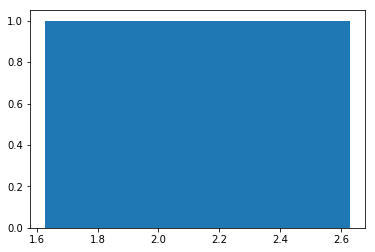

/Users/michael.zhang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/michael.zhang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


DescribeResult(nobs=1, minmax=(2.128412610127082, 2.128412610127082), mean=2.128412610127082, variance=nan, skewness=0.0, kurtosis=-3.0)

In [56]:
from matplotlib import pyplot as plt
from scipy import stats
#hos_train_mape_new = [hos_train_mape[i] for i in range(0,len(hos_train_mape),4)]
print(np.mean(hos_train_mape))
plt.hist(np.array(hos_train_mape), bins='auto')
plt.show()
    
stats.describe(hos_train_mape)

0.020965938950830345


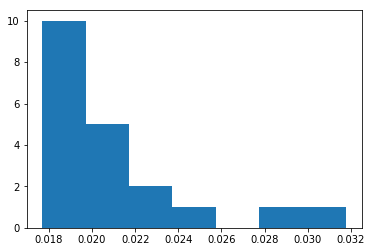

DescribeResult(nobs=20, minmax=(0.01768131456557392, 0.031794319243132974), mean=0.020965938950830345, variance=1.308783656381357e-05, skewness=1.7451639048745087, kurtosis=2.4587664527024886)

In [70]:
print(np.mean(hos_train_rmse))
plt.hist(np.array(hos_train_rmse), bins='auto')
plt.show()

stats.describe(hos_train_rmse)

In [71]:
k = [hos_train_error85[i][(hos_train_error85[i]>0.1) | (hos_train_error85[i]<-0.1)].shape[0] for i in range(len(hos_train_error85))]

np.mean(k)

54.85

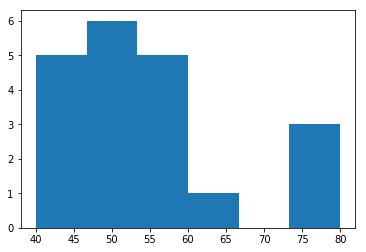

In [72]:
plt.hist(k, bins='auto')
plt.show()

In [73]:
np.median(hos_train_mape)

2.5546562641219346

In [74]:
cpik.dump(hos_train_mape, open( "inside compare/hos/20/3_Hospitality_3channel_mape.pkl", "wb" )) 
cpik.dump(hos_train_rmse, open( "inside compare/hos/20/3_Hospitality_3channel_rmse.pkl", "wb" )) 
cpik.dump(hos_train_error85, open( "inside compare/hos/20/3_Hospitality_3channel_error85.pkl", "wb" )) 

##  2- Retail

In [38]:
ret_df = pd.read_csv('4_retail_13months.csv').iloc[:, 1:8]

neighbours_index_image_arys = cpik.load(open("4_retail_13months_3channel.pkl", "rb" ))
ret_df['neighbours_index_image'] = neighbours_index_image_arys.tolist()
ret_df['neighbours_index_image'] = ret_df['neighbours_index_image'].apply(lambda x : np.array(x))
print(ret_df['neighbours_index_image'].shape, ret_df['neighbours_index_image'].iloc[0].shape)
ts = 3

(4212,) (7, 7, 3)


In [39]:
# Build up dateset
X_train_ret, Y_train_ret, X_test_ret, Y_test_ret= build_dl_dataset_by_ts(ret_df, ts)
X_train_ret = np.array(X_train_ret)
X_train_ret = np.nan_to_num(X_train_ret)

Y_train_ret = np.array(Y_train_ret)
Y_train_ret = Y_train_ret.reshape(Y_train_ret.shape[0],Y_train_ret.shape[1],1)
Y_train_ret = np.nan_to_num(Y_train_ret)


X_test_ret = np.array(X_test_ret)
X_test_ret = np.nan_to_num(X_test_ret)

Y_test_ret = np.array(Y_test_ret)
Y_test_ret = Y_test_ret.reshape(Y_test_ret.shape[0],Y_test_ret.shape[1],1)
Y_test_ret = np.nan_to_num(Y_test_ret)

In [40]:
print(X_train_ret.shape, Y_train_ret.shape, X_test_ret.shape, Y_test_ret.shape)

(2916, 3, 7, 7, 3) (2916, 3, 1) (324, 3, 7, 7, 3) (324, 3, 1)


In [116]:
#ret_train_mape, ret_test_mape, ret_train_rmse, \
#ret_test_rmse, ret_train_error85, ret_test_error85 \
#    = get_performance(30, X_train_ret, Y_train_ret, X_test_ret, Y_test_ret)

Finished 0 times
Finished 10 times
Finished 20 times


In [57]:
inputshapes = X_train_ret.shape[1:]
cnnlstm = cnn_on_lstm_rms_model(64, 64, 0.1, 0.1, 16, inputshapes, mape_loss)
cnnlstm.fit(X_train_ret, Y_train_ret, batch_size = 64,epochs=50,verbose=0) #
cnnlstm

In [58]:
cnnlstm.save('retail_DL.h5')
del cnnlstm  

In [59]:
cnnlstm = load_model('retail_DL.h5', custom_objects={'mape_loss': mape_loss})

In [60]:

Y_train_ret_pred = cnnlstm.predict(X_train_ret)
Y_test_ret_pred = cnnlstm.predict(X_test_ret)

Y_train_ret_pred = Y_train_ret_pred[:,-1,:].flatten()
Y_train_ret_true = Y_train_ret[:,-1,:].flatten()

Y_test_ret_pred = Y_test_ret_pred[:,-1,:].flatten()
Y_test_ret_true = Y_test_ret[:,-1,:].flatten()


# mape train
ret_train_mape = mape(Y_train_ret_pred, Y_train_ret_true)

# mape test
ret_test_mape = mape(Y_test_ret_pred, Y_test_ret_true)


# rmse train
ret_train_rmse = rmse(Y_train_ret_pred, Y_train_ret_true)

# rmse test
rettest_rmse = rmse(Y_test_ret_pred, Y_test_ret_true)

2.247980970993006


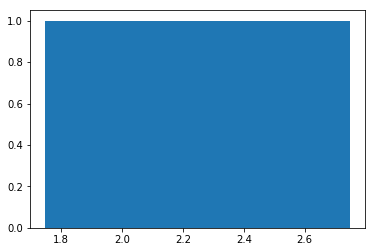

/Users/michael.zhang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/michael.zhang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


DescribeResult(nobs=1, minmax=(2.247980970993006, 2.247980970993006), mean=2.247980970993006, variance=nan, skewness=0.0, kurtosis=-3.0)

In [61]:
from matplotlib import pyplot as plt
from scipy import stats
#hos_train_mape_new = [hos_train_mape[i] for i in range(0,len(hos_train_mape),4)]
print(np.mean(ret_train_mape))
plt.hist(np.array(ret_train_mape), bins='auto')
plt.show()
stats.describe(ret_train_mape)

0.017073103026324855


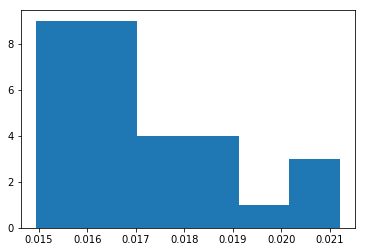

DescribeResult(nobs=30, minmax=(0.014938034071847898, 0.021209201438923266), mean=0.017073103026324855, variance=2.859474756956291e-06, skewness=1.0645876343194982, kurtosis=0.2586068551297718)

In [118]:
print(np.mean(ret_train_rmse))
plt.hist(np.array(ret_train_rmse), bins='auto')
plt.show()
stats.describe(ret_train_rmse)

In [119]:
#t = hos_train_error85[3]
#t[(t>0.1) | (t<-0.1)].shape, t.shape

k = [ret_train_error85[i][(ret_train_error85[i]>0.1) | (ret_train_error85[i]<-0.1)].shape[0] for i in range(len(ret_train_error85))]

np.mean(k)

50.733333333333334

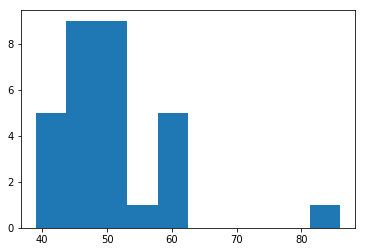

In [120]:
plt.hist(k, bins='auto')
plt.show()

In [121]:
cpik.dump(ret_train_mape, open( "inside compare/ret/30/3_Retail_3channel_mape.pkl", "wb" )) 
cpik.dump(ret_train_rmse, open( "inside compare/ret/30/3_Retail_3channel_rmse.pkl", "wb" )) 
cpik.dump(ret_train_error85, open( "inside compare/ret/30/3_Retail_3channel_error85.pkl", "wb" )) 

##  3- Building

In [62]:
bud_df = pd.read_csv('1_building_13months.csv').iloc[:, 1:8]

neighbours_index_image_arys = cpik.load(open("1_building_13months_3channel.pkl", "rb" ))
bud_df['neighbours_index_image'] = neighbours_index_image_arys.tolist()
bud_df['neighbours_index_image'] = bud_df['neighbours_index_image'].apply(lambda x : np.array(x))
print(bud_df['neighbours_index_image'].shape, bud_df['neighbours_index_image'].iloc[0].shape)
ts = 3

(4498,) (7, 7, 3)


In [63]:
# Build up dateset
X_train_bud, Y_train_bud, X_test_bud, Y_test_bud= build_dl_dataset_by_ts(bud_df, ts)
X_train_bud = np.array(X_train_bud)
X_train_bud = np.nan_to_num(X_train_bud)

Y_train_bud = np.array(Y_train_bud)
Y_train_bud = Y_train_bud.reshape(Y_train_bud.shape[0],Y_train_bud.shape[1],1)
Y_train_bud = np.nan_to_num(Y_train_bud)


X_test_bud = np.array(X_test_bud)
X_test_bud = np.nan_to_num(X_test_bud)

Y_test_bud = np.array(Y_test_bud)
Y_test_bud = Y_test_bud.reshape(Y_test_bud.shape[0],Y_test_bud.shape[1],1)
Y_test_bud = np.nan_to_num(Y_test_bud)

In [64]:
print(X_train_bud.shape, Y_train_bud.shape, X_test_bud.shape, Y_test_bud.shape)

(3114, 3, 7, 7, 3) (3114, 3, 1) (346, 3, 7, 7, 3) (346, 3, 1)


In [17]:
#bud_train_mape, bud_test_mape, bud_train_rmse,\
#bud_test_rmse, bud_train_error85, bud_test_error85 \
#       = get_performance(30, X_train_bud, Y_train_bud, X_test_bud, Y_test_bud)

Finished 0 times
Finished 10 times
Finished 20 times


In [65]:
inputshapes = X_train_bud.shape[1:]
cnnlstm = cnn_on_lstm_rms_model(64, 64, 0.1, 0.1, 64, inputshapes, mape_loss)
cnnlstm.fit(X_train_bud, Y_train_bud, batch_size = 64,epochs=50,verbose=0) #
cnnlstm

In [66]:
cnnlstm.save('building_DL.h5')
del cnnlstm

In [68]:
cnnlstm = load_model('building_DL.h5', custom_objects={'mape_loss': mape_loss})

In [69]:
Y_train_bud_pred = cnnlstm.predict(X_train_bud)
Y_test_bud_pred = cnnlstm.predict(X_test_bud)

Y_train_bud_pred = Y_train_bud_pred[:,-1,:].flatten()
Y_train_bud_true = Y_train_bud[:,-1,:].flatten()
Y_test_bud_pred = Y_test_bud_pred[:,-1,:].flatten()
Y_test_bud_true = Y_test_bud[:,-1,:].flatten()


# mape train

bud_train_mape = mape(Y_train_bud_pred, Y_train_bud_true)

# mape test
bud_test_mape = mape(Y_test_bud_pred, Y_test_bud_true)


# rmse train
bud_train_rmse = rmse(Y_train_bud_pred, Y_train_bud_true)

# rmse test
bud_test_rmse = rmse(Y_test_bud_pred, Y_test_bud_true)

3.5594101863403353


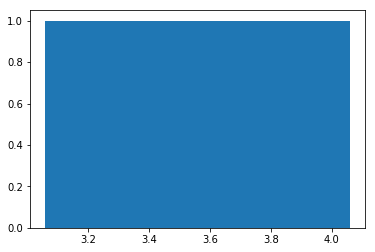

/Users/michael.zhang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/michael.zhang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


DescribeResult(nobs=1, minmax=(3.5594101863403353, 3.5594101863403353), mean=3.5594101863403353, variance=nan, skewness=0.0, kurtosis=-3.0)

In [70]:
from matplotlib import pyplot as plt
from scipy import stats
#hos_train_mape_new = [hos_train_mape[i] for i in range(0,len(hos_train_mape),4)]
print(np.mean(bud_train_mape))
plt.hist(np.array(bud_train_mape), bins='auto')
plt.show()
stats.describe(bud_train_mape)

0.022616705626699703


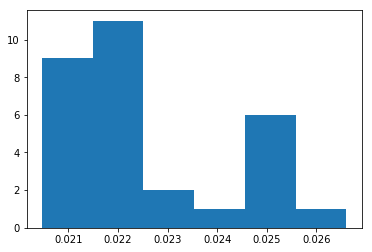

DescribeResult(nobs=30, minmax=(0.020467789712377903, 0.02660914689354507), mean=0.022616705626699703, variance=2.817997834051327e-06, skewness=0.868002071435494, kurtosis=-0.5119462598036568)

In [19]:
print(np.mean(bud_train_rmse))
plt.hist(np.array(bud_train_rmse), bins='auto')
plt.show()
stats.describe(bud_train_rmse)

In [20]:

k = [bud_train_error85[i][(bud_train_error85[i]>0.1) | (bud_train_error85[i]<-0.1)].shape[0] for i in range(len(bud_train_error85))]

np.mean(k)

60.333333333333336

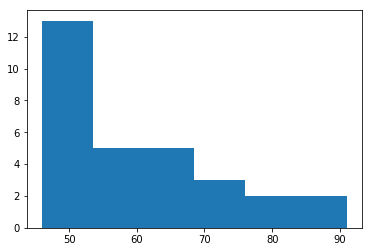

In [21]:
plt.hist(k, bins='auto')
plt.show()

In [22]:
cpik.dump(bud_train_mape, open( "inside compare/bud/30/3_Retail_3channel_mape.pkl", "wb" )) 
cpik.dump(bud_train_rmse, open( "inside compare/bud/30/3_Retail_3channel_rmse.pkl", "wb" )) 
cpik.dump(bud_train_error85, open( "inside compare/bud/30/3_Retail_3channel_error85.pkl", "wb" )) 

##  4- Prof

In [95]:
bud_df = pd.read_csv('2_profession_13months.csv').iloc[:, 1:8]

neighbours_index_image_arys = cpik.load(open("2_profession_13months_3channel.pkl", "rb" ))
bud_df['neighbours_index_image'] = neighbours_index_image_arys.tolist()
bud_df['neighbours_index_image'] = bud_df['neighbours_index_image'].apply(lambda x : np.array(x))
print(bud_df['neighbours_index_image'].shape, bud_df['neighbours_index_image'].iloc[0].shape)
ts = 3

(4303,) (7, 7, 3)


In [96]:
# Build up dateset
X_train_bud, Y_train_bud, X_test_bud, Y_test_bud= build_dl_dataset_by_ts(bud_df, ts)
X_train_bud = np.array(X_train_bud)
X_train_bud = np.nan_to_num(X_train_bud)

Y_train_bud = np.array(Y_train_bud)
Y_train_bud = Y_train_bud.reshape(Y_train_bud.shape[0],Y_train_bud.shape[1],1)
Y_train_bud = np.nan_to_num(Y_train_bud)


X_test_bud = np.array(X_test_bud)
X_test_bud = np.nan_to_num(X_test_bud)

Y_test_bud = np.array(Y_test_bud)
Y_test_bud = Y_test_bud.reshape(Y_test_bud.shape[0],Y_test_bud.shape[1],1)
Y_test_bud = np.nan_to_num(Y_test_bud)

In [97]:
print(X_train_bud.shape, Y_train_bud.shape, X_test_bud.shape, Y_test_bud.shape)

(2979, 3, 7, 7, 3) (2979, 3, 1) (331, 3, 7, 7, 3) (331, 3, 1)


In [98]:
inputshapes = X_train_bud.shape[1:]
cnnlstm = cnn_on_lstm_rms_model(128, 64, 0.1, 0.1, 64, inputshapes, mape_loss)
cnnlstm.fit(X_train_bud, Y_train_bud, batch_size = 64,epochs=50,verbose=0) #
cnnlstm

In [99]:
cnnlstm.save('prof_DL.h5')
del cnnlstm

In [100]:
cnnlstm = load_model('prof_DL.h5', custom_objects={'mape_loss': mape_loss})

In [101]:
Y_train_bud_pred = cnnlstm.predict(X_train_bud)
Y_test_bud_pred = cnnlstm.predict(X_test_bud)

Y_train_bud_pred = Y_train_bud_pred[:,-1,:].flatten()
Y_train_bud_true = Y_train_bud[:,-1,:].flatten()
Y_test_bud_pred = Y_test_bud_pred[:,-1,:].flatten()
Y_test_bud_true = Y_test_bud[:,-1,:].flatten()


# mape train

bud_train_mape = mape(Y_train_bud_pred, Y_train_bud_true)

# mape test
bud_test_mape = mape(Y_test_bud_pred, Y_test_bud_true)


# rmse train
bud_train_rmse = rmse(Y_train_bud_pred, Y_train_bud_true)

# rmse test
bud_test_rmse = rmse(Y_test_bud_pred, Y_test_bud_true)

4.257970441370843


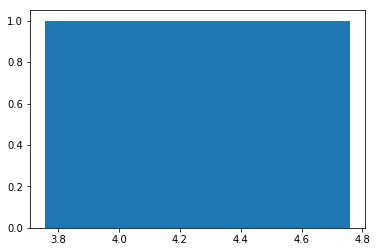

/Users/michael.zhang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/michael.zhang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


DescribeResult(nobs=1, minmax=(4.257970441370843, 4.257970441370843), mean=4.257970441370843, variance=nan, skewness=0.0, kurtosis=-3.0)

In [102]:
from matplotlib import pyplot as plt
from scipy import stats
#hos_train_mape_new = [hos_train_mape[i] for i in range(0,len(hos_train_mape),4)]
print(np.mean(bud_train_mape))
plt.hist(np.array(bud_train_mape), bins='auto')
plt.show()
stats.describe(bud_train_mape)